In [12]:
# General imports
import pickle
import copy
from pathlib import Path
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime

# Pytorch imports
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

from lunar_lander import LunarLander

In [13]:
# Set Seaborn aesthetics
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titlelocation'] = 'left'
plt.style.use('ggplot')

# Environment

In [14]:
env = LunarLander()

In [24]:
env = gym.make("LunarLander-v2")

KeyError: 'render_modes'

In [18]:
#print(f'Reward threshold is: {env.spec.reward_threshold}')
print(f'Reward range is: {env.reward_range}')
#print(f'Maximun number of steps per episode: {env.spec.max_episode_steps}')
print(f'Action space dimmension is: {env.action_space.n}')
#print(f'Actions are: {env.get_action_meanings()}')
print(f'Observation space dimmension is: {env.observation_space.shape}')

Reward range is: (-inf, inf)
Action space dimmension is: 4
Observation space dimmension is: (8,)


In [27]:
def play_random_episode(env:gym.Env) -> tuple[float, int]:
    '''Plays a random episode and returns the total reward and number of steps taken'''
    # Environment initialization
    obs = env.reset()
    total_reward, done, steps = 0, False, 0
    
    while not done:
        # Elegir una acción aleatoria (implementación del agente)
        action = env.action_space.sample()
        # Ejecutar la acción y esperar la respuesta del entorno
        new_obs, reward, done, info, _ = env.step(action)
        # Actualizar variables
        obs = new_obs
        steps += 1
        total_reward += reward

    env.close()
    return total_reward, steps

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
play_random_episode(env)

In [ ]:
def play_random_episodes(env:gym.Env, n_episodes:int) -> tuple[np.ndarray, np.ndarray]:
    '''Plays n_episodes random episodes and returns the total reward and number of steps taken'''
    total_rewards = []
    n_steps = []
    for i in tqdm(range(n_episodes)):
        total_reward, steps = play_random_episode(env)
        total_rewards.append(total_reward)
        n_steps.append(steps)
    return np.array(total_rewards), np.array(n_steps)


n_episodes = 1000
total_rewards, n_steps = play_random_episodes(env, n_episodes)

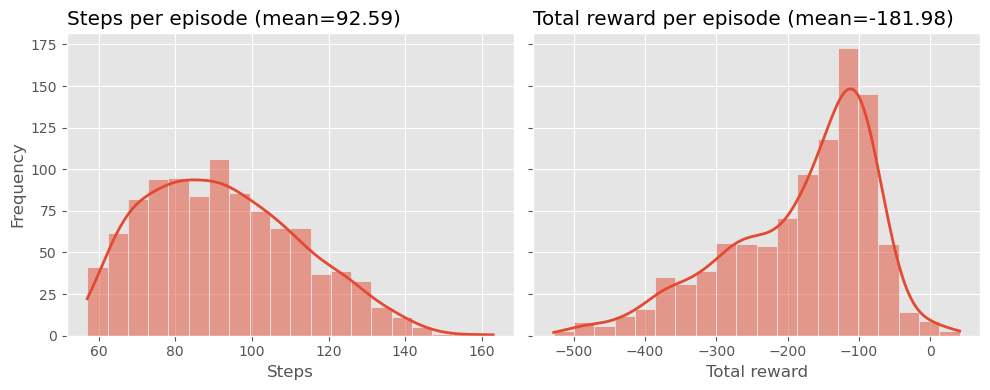

In [28]:
# Plotting the results
def plot_results_hist(n_steps, total_rewards):
    fig, ax = plt.subplots(1,2,figsize=(10,4), sharey=True)
    sns.histplot(x=n_steps, ax=ax[0], bins=20, kde=True)
    ax[0].set_title(f'Steps per episode (mean={n_steps.mean():.2f})')
    ax[0].set_xlabel('Steps')
    ax[0].set_ylabel('Frequency')
    sns.histplot(x=total_rewards, ax=ax[1], bins=20, kde=True)
    ax[1].set_title(f'Total reward per episode (mean={total_rewards.mean():.2f})')
    ax[1].set_xlabel('Total reward')
    ax[1].set_ylabel('Frequency')
    fig.tight_layout()
    plt.show()
    
plot_results_hist(n_steps, total_rewards)

# Reference agent: DQN

# Proposed agent